This code imports essential libraries for building, training, and evaluating a PyTorch CNN on images (NumPy, PIL, Torch, TorchVision, Matplotlib) along with optimization and transformation utilities.


In [1]:
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimm

import matplotlib.pyplot as plt
from PIL import Image

import torchvision
import torchvision.transforms as transforms

This cocde converts images into tensors and normalizes pixel values of all RGB channels to the range [-1, 1].

In [2]:
 transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

This code downloads the CIFAR-10 dataset, applies the transform to images, and then loads them into mini-batches using 'DataLoader' for training 'batch_size=4', shuffled and testing 'batch_size=32', shuffled.

The CIFAR-10 dataset is primarily used for image classification tasks and testing deep learning models. It contains 60,000 color images of size 32x32 pixels, divided into 10 distinct classes. There are 50,000 training images and 10,000 test images for evaluation.

In [3]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True, num_workers=2)

100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


This code retrieves the first image and its corresponding label from the CIFAR-10 training dataset.

In [4]:
image, label = train_data[0]

This code returns the dimensions (channels, height, width) of the image tensor.


In [5]:
image.size()

torch.Size([3, 32, 32])

This code defines a CNN with three convolution–batchnorm–ReLU–pooling blocks followed by fully connected layers with dropout, outputting class scores for 10 CIFAR-10 categories.

A Convolution Neural Network(CNN) is a type of Deep Learning model mainly used for image and video recognition. It automatiucally learns features from data using convolution layrs that apply filters to detect patterns like edges and shapes.

In [6]:
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

This code builds a CNN that extracts features through three conv-batchnorm-ReLU-pool layers, flattens them, and classifies into 10 classes using fully connected layers with dropout. In this project I've used three convolution layers, one pooling layer, and three fully connected layers.

A convolution layer is the core building block of a CNN that extracts features from input data. It uses filters(kernels) that slide over the input to detect the local patterns like edges, textures, or shapes. The layers apply operations like dot products and summation between the filter and the input region.

A pooling layer is used in CNNs to reduce the spatial size of feature maps. Pooling makes the model more robust to small shifts and distortions in the input image.

A fully connected (FC) layer connects every neuron in one layer to every neuron in the next layer.
It combines the features learned by convolution and pooling layers to make final predictions.

In [7]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolution layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # 32x32 -> 4x4 after pooling 3 times
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

This code initializes the CNN model, sets cross-entropy as the loss function, and configures SGD with learning rate 0.001 and momentum 0.9 as the optimizer.

In [8]:
net = NeuralNet()
loss_function = nn.CrossEntropyLoss()
optimizer = optimm.SGD(net.parameters(), lr=0.001, momentum=0.9)

This code trains the network for 8 epochs by looping over training batches, computing loss, backpropagating, updating weights, and printing the average loss per epoch.

In [9]:
for epoch in range(8):
  print(f'Epoch: {epoch}')

  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f'Loss: {running_loss / len(train_loader):4f}')

Epoch: 0
Loss: 1.687031
Epoch: 1
Loss: 1.344379
Epoch: 2
Loss: 1.159476
Epoch: 3
Loss: 1.039259
Epoch: 4
Loss: 0.934226
Epoch: 5
Loss: 0.853483
Epoch: 6
Loss: 0.792184
Epoch: 7
Loss: 0.744930


This code saves the trained model’s learned parameters 'state_dict' into a file named 'trained_net.pth'.


In [11]:
 torch.save(net.state_dict(), 'trained_net.pth')

This code creates a new NeuralNet model and loads the previously saved trained parameters from 'trained_net.pth' into it.


This code initializes a fresh NeuralNet model and restores its weights from the saved file 'trained_net.pth'.


In [12]:
net = NeuralNet()
net.load_state_dict(torch.load('trained_net.pth'))

<All keys matched successfully>

This code evaluates the trained model on the test set by comparing predictions with true labels and computes the overall classification accuracy.

In [13]:
correct = 0
total = 0

net.eval()

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy}')

Accuracy: 76.04


In [14]:
correct = 0
total = 0

net.eval()

with torch.no_grad():
  for data in train_loader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy}')

Accuracy: 82.086


This code loads custom images, preprocesses them with resizing and normalization, and displays each using Matplotlib with its filename as the title.

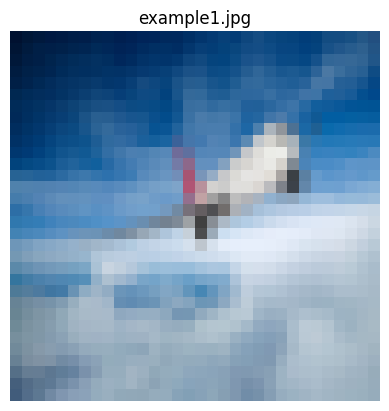

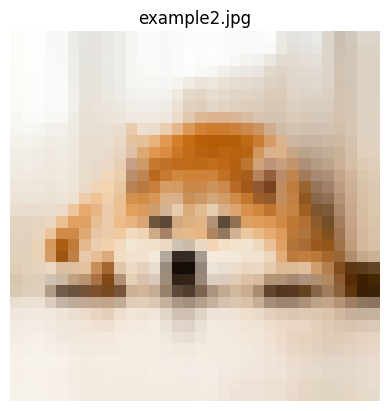

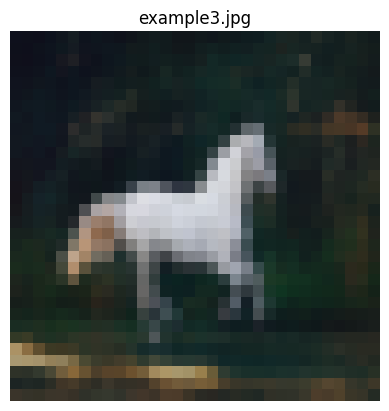

In [ ]:
new_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# List of image file paths
image_paths = ['example1.jpg', 'example2.jpg', 'example3.jpg']

# Function for displaying an image
def show_image(img_tensor, title=None):
    # Unnormalization
    img_tensor = img_tensor / 2 + 0.5
    npimg = img_tensor.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Loading and displaying images
for path in image_paths:
    img = Image.open(path).convert('RGB')      # Opening image
    img_tensor = new_transform(img)            # Applying transform
    show_image(img_tensor, title=path)

This code loads and preprocesses custom images, passes them through the trained model in evaluation mode, and prints the predicted class labels.

In [ ]:
new_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


def load_image(image_path):
    image = Image.open(image_path)
    image = new_transform(image)
    image = image.unsqueeze(0)  # adding batch dimension
    return image

image_path = ['example1.jpg', 'example2.jpg', 'example3.jpg']
images = [load_image(img) for img in image_paths]

net.eval()
with torch.no_grad():
    for image in images:
        output = net(image)
        _, predicted = torch.max(output.data, 1)
        print(f'Prediction: {class_names[predicted.item()]}')

Prediction: plane
Prediction: cat
Prediction: horse
